In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
PROJECT_ROOT = "/content/drive/MyDrive/Thoriq/UAP_Birds_Classification"

DATASET_DIR = f"{PROJECT_ROOT}/dataset/processed"
MODEL_DIR = f"{PROJECT_ROOT}/models"
RESULT_DIR = f"{PROJECT_ROOT}/results/cnn"

# CNN base

Import Library

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Parameter Training

In [10]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001

Data Generator

In [11]:
train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    DATASET_DIR + "/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_data = val_gen.flow_from_directory(
    DATASET_DIR + "/val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_data = test_gen.flow_from_directory(
    DATASET_DIR + "/test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

NUM_CLASSES = train_data.num_classes
print("Jumlah kelas:", NUM_CLASSES)

Found 3848 images belonging to 4 classes.
Found 36 images belonging to 4 classes.
Found 42 images belonging to 4 classes.
Jumlah kelas: 4


Arsitektur CNN

In [12]:
model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(224,224,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation="softmax")
])

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,245,700 (84.86 MB)

 Trainable params: 22,245,700 (84.86 MB)

 Non-trainable params: 0 (0.00 B)

Training Model

In [13]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[early_stop]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 1326s 11s/step - accuracy: 0.5499 - loss: 1.2465 - val_accuracy: 0.8056 - val_loss: 1.8364
Epoch 2/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 23s 186ms/step - accuracy: 0.9165 - loss: 0.2792 - val_accuracy: 0.6667 - val_loss: 3.0872
Epoch 3/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 20s 166ms/step - accuracy: 0.9262 - loss: 0.2074 - val_accuracy: 0.8333 - val_loss: 2.7247
Epoch 4/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 0.9576 - loss: 0.1161 - val_accuracy: 0.8056 - val_loss: 5.2830
Epoch 5/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - accuracy: 0.9715 - loss: 0.0860 - val_accuracy: 0.8611 - val_loss: 3.6546
Epoch 6/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - accuracy: 0.9639 - loss: 0.1257 - val_accuracy: 0.8056 - val_loss: 7.5534


Simpan Model

In [14]:
model.save(f"{MODEL_DIR}/cnn_scratch.h5")
print("Model CNN Scratch disimpan ✅")

Model CNN Scratch disimpan ✅


Grafik Accuracy & Loss

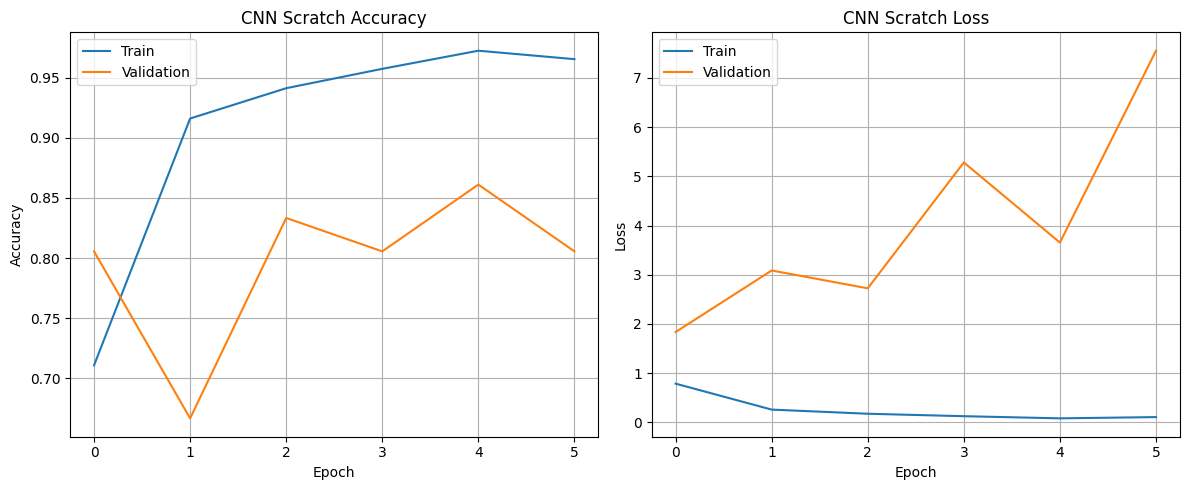

In [15]:
os.makedirs(RESULT_DIR, exist_ok=True)

plt.figure(figsize=(12, 5))

# ======================
# Accuracy
# ======================
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.title("CNN Scratch Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# ======================
# Loss
# ======================
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.title("CNN Scratch Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Simpan & tampilkan
plt.tight_layout()
plt.savefig(f"{RESULT_DIR}/training_curve.png")
plt.show()

Evaluasi Test Set

In [16]:
test_data.reset()
pred = model.predict(test_data)
y_pred = np.argmax(pred, axis=1)
y_true = test_data.classes
class_names = list(test_data.class_indices.keys())

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 907ms/step


Classification Report

In [17]:
report = classification_report(
    y_true,
    y_pred,
    target_names=class_names
)

print(report)

with open(f"{RESULT_DIR}/classification_report.txt", "w") as f:
    f.write(report)

                         precision    recall  f1-score   support

amazon green parrot.jpg       0.83      0.91      0.87        11
        gray parrot.jpg       0.61      0.92      0.73        12
              macaw.jpg       0.92      1.00      0.96        11
       white parrot.jpg       0.00      0.00      0.00         8

               accuracy                           0.76        42
              macro avg       0.59      0.71      0.64        42
           weighted avg       0.63      0.76      0.69        42



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Confusion Matrix

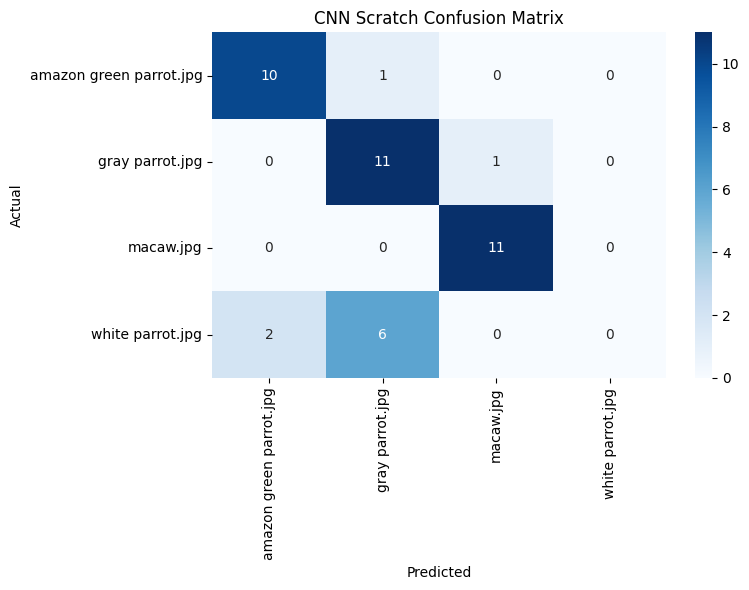

In [21]:

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.title("CNN Scratch Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(f"{RESULT_DIR}/confusion_matrix.png")
plt.show()


In [20]:
import numpy as np

unique_preds, counts = np.unique(y_pred, return_counts=True)
print(dict(zip(unique_preds, counts)))


{np.int64(0): np.int64(12), np.int64(1): np.int64(18), np.int64(2): np.int64(12)}


# MobileNetV2

In [49]:
PROJECT_ROOT = "/content/drive/MyDrive/Thoriq/UAP_Birds_Classification"

DATASET_DIR = f"{PROJECT_ROOT}/dataset/processed"
MODEL_DIR = f"{PROJECT_ROOT}/models"
RESULT_DIR = f"{PROJECT_ROOT}/results/mobilenetv2"

Import Library

In [50]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Parameter Training

In [51]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-4

Data Generator

In [52]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    DATASET_DIR + "/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_data = val_gen.flow_from_directory(
    DATASET_DIR + "/val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_data = test_gen.flow_from_directory(
    DATASET_DIR + "/test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

NUM_CLASSES = train_data.num_classes
print("Jumlah kelas:", NUM_CLASSES)

Found 4993 images belonging to 4 classes.
Found 36 images belonging to 4 classes.
Found 42 images belonging to 4 classes.
Jumlah kelas: 4


Load MobileNetV2 Pretrained

In [53]:
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

# Freeze sebagian besar layer
for layer in base_model.layers[:-10]:
    layer.trainable = False
for layer in base_model.layers[-10:]:
    layer.trainable = True

Tambahkan Custom Classifier

In [54]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.6)(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,427,588 (9.26 MB)

 Trainable params: 899,524 (3.43 MB)

 Non-trainable params: 1,528,064 (5.83 MB)

Training Model

In [55]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,
    min_lr=1e-6,
    verbose=1
)
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 100s 550ms/step - accuracy: 0.6964 - loss: 0.8870 - val_accuracy: 1.0000 - val_loss: 0.0290 - learning_rate: 1.0000e-04
Epoch 2/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 73s 464ms/step - accuracy: 0.9648 - loss: 0.1007 - val_accuracy: 1.0000 - val_loss: 0.0152 - learning_rate: 1.0000e-04
Epoch 3/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 74s 467ms/step - accuracy: 0.9779 - loss: 0.0685 - val_accuracy: 1.0000 - val_loss: 0.0147 - learning_rate: 1.0000e-04
Epoch 4/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 73s 464ms/step - accuracy: 0.9812 - loss: 0.0522 - val_accuracy: 1.0000 - val_loss: 0.0245 - learning_rate: 1.0000e-04
Epoch 5/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 72s 460ms/step - accuracy: 0.9878 - loss: 0.0420 - val_accuracy: 1.0000 - val_loss: 0.0126 - learning_rate: 1.0000e-04
Epoch 6/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 72s 458ms/step - accuracy: 0.9914 - loss: 0.0291 - val_accuracy: 0.9722 - val_loss: 0.0299 - learning_rate: 1.0000e-04
Epoch 7/20
157/157 ━━━━━━━━━━━━━━━━━━━━ 73s 4

Simpan Model

In [56]:
os.makedirs(MODEL_DIR, exist_ok=True)
model.save(f"{MODEL_DIR}/mobilenetv21.h5")
print("Model MobileNetV2 disimpan ✅")

Model MobileNetV2 disimpan ✅


Grafik Accuracy & Loss

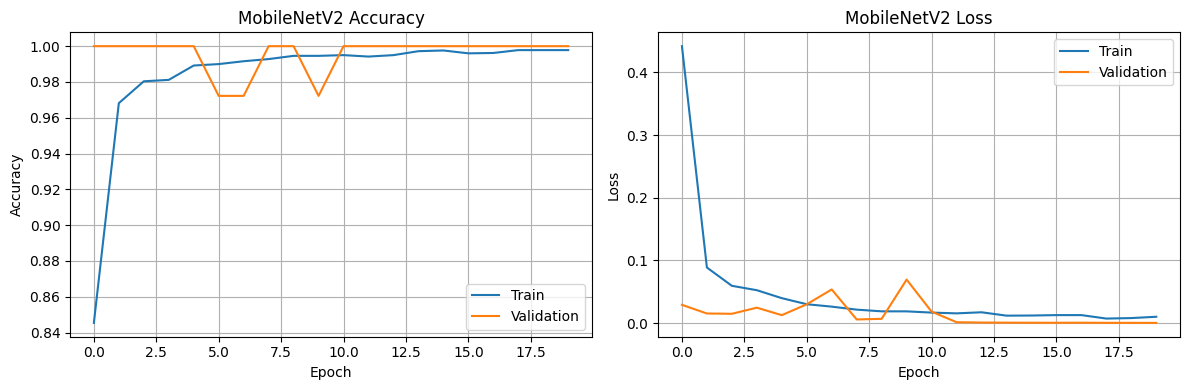

In [57]:
os.makedirs(RESULT_DIR, exist_ok=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# =======================
# Accuracy
# =======================
axes[0].plot(history.history["accuracy"], label="Train")
axes[0].plot(history.history["val_accuracy"], label="Validation")
axes[0].set_title("MobileNetV2 Accuracy")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].legend()
axes[0].grid(True)

# =======================
# Loss
# =======================
axes[1].plot(history.history["loss"], label="Train")
axes[1].plot(history.history["val_loss"], label="Validation")
axes[1].set_title("MobileNetV2 Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig(f"{RESULT_DIR}/accuracy_loss.png")
plt.show()

Evaluasi Test Set

In [58]:
test_data.reset()
pred = model.predict(test_data)
y_pred = np.argmax(pred, axis=1)
y_true = test_data.classes
class_names = list(test_data.class_indices.keys())

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step


Classification Report

In [59]:
report = classification_report(
    y_true,
    y_pred,
    target_names=class_names
)

print(report)

with open(f"{RESULT_DIR}/classification_report.txt", "w") as f:
    f.write(report)

                         precision    recall  f1-score   support

amazon green parrot.jpg       1.00      1.00      1.00        11
        gray parrot.jpg       1.00      1.00      1.00        12
              macaw.jpg       1.00      1.00      1.00        11
       white parrot.jpg       1.00      1.00      1.00         8

               accuracy                           1.00        42
              macro avg       1.00      1.00      1.00        42
           weighted avg       1.00      1.00      1.00        42



Confusion Matrix

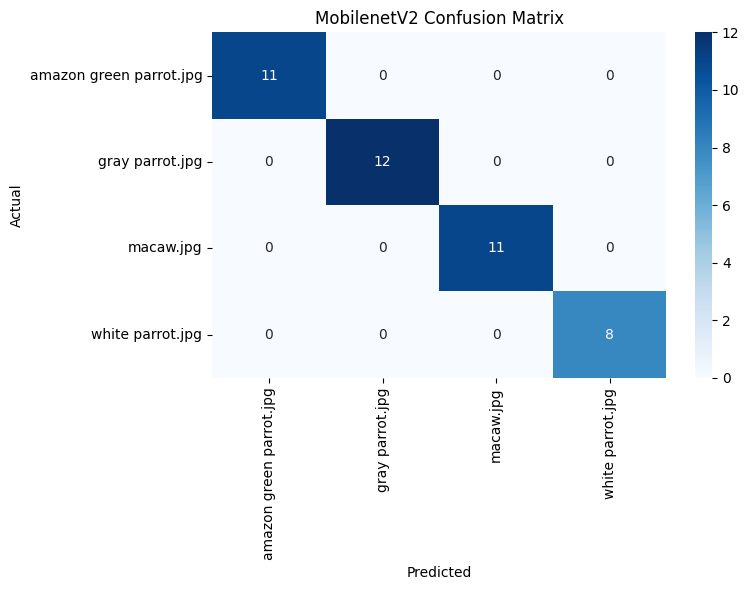

In [60]:

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.title("MobilenetV2 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(f"{RESULT_DIR}/confusion_matrix.png")
plt.show()


# ResNet50

In [36]:
PROJECT_ROOT = "/content/drive/MyDrive/Thoriq/UAP_Birds_Classification"

DATASET_DIR = f"{PROJECT_ROOT}/dataset/processed"
MODEL_DIR = f"{PROJECT_ROOT}/models"
RESULT_DIR = f"{PROJECT_ROOT}/results/resnet50"

Import Library

In [37]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Parameter Training

In [38]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16   # ResNet lebih berat
EPOCHS = 15
LEARNING_RATE = 0.0001

Data Generator

In [39]:
train_gen = ImageDataGenerator(rescale=1./255)
val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    DATASET_DIR + "/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_data = val_gen.flow_from_directory(
    DATASET_DIR + "/val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_data = test_gen.flow_from_directory(
    DATASET_DIR + "/test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

NUM_CLASSES = train_data.num_classes
print("Jumlah kelas:", NUM_CLASSES)

Found 4993 images belonging to 4 classes.
Found 36 images belonging to 4 classes.
Found 42 images belonging to 4 classes.
Jumlah kelas: 4


Load ResNet50 Pretrained

In [40]:
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False  # freeze backbone

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Tambahkan Custom Classifier

In [41]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Training Model

In [42]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    callbacks=[early_stop]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 52s 110ms/step - accuracy: 0.2513 - loss: 1.5633 - val_accuracy: 0.3333 - val_loss: 1.3102
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step - accuracy: 0.3060 - loss: 1.3730 - val_accuracy: 0.5000 - val_loss: 1.2996
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - accuracy: 0.3447 - loss: 1.3421 - val_accuracy: 0.3889 - val_loss: 1.3032
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - accuracy: 0.3611 - loss: 1.3234 - val_accuracy: 0.4167 - val_loss: 1.2605
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step - accuracy: 0.3772 - loss: 1.3107 - val_accuracy: 0.4722 - val_loss: 1.2525
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 72ms/step - accuracy: 0.3800 - loss: 1.2953 - val_accuracy: 0.5000 - val_loss: 1.2316
Epoch 7/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - accuracy: 0.3872 - loss: 1.2888 - val_accuracy: 0.4722 - val_loss: 1.2251
Epoch 8/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 75ms/step - accuracy: 0.4194 - loss: 1.2714 -

Simpan Model

In [43]:
os.makedirs(MODEL_DIR, exist_ok=True)
model.save(f"{MODEL_DIR}/resnet50.h5")
print("Model ResNet50 disimpan ✅")

Model ResNet50 disimpan ✅


Grafik Accuracy & Loss

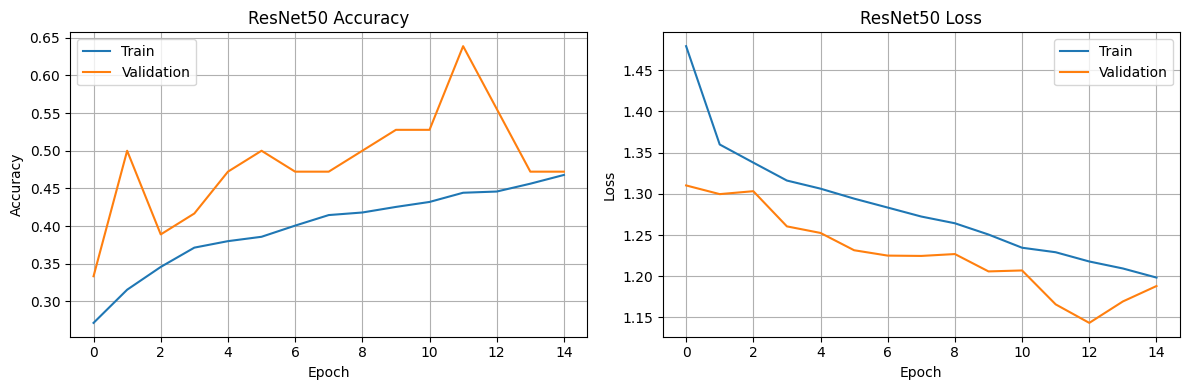

In [44]:
os.makedirs(RESULT_DIR, exist_ok=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# =======================
# Accuracy
# =======================
axes[0].plot(history.history["accuracy"], label="Train")
axes[0].plot(history.history["val_accuracy"], label="Validation")
axes[0].set_title("ResNet50 Accuracy")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].legend()
axes[0].grid(True)

# =======================
# Loss
# =======================
axes[1].plot(history.history["loss"], label="Train")
axes[1].plot(history.history["val_loss"], label="Validation")
axes[1].set_title("ResNet50 Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig(f"{RESULT_DIR}/accuracy_loss.png")
plt.show()

Evaluasi Test Set

In [45]:
test_data.reset()
pred = model.predict(test_data)
y_pred = np.argmax(pred, axis=1)
y_true = test_data.classes
class_names = list(test_data.class_indices.keys())

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step


Classification Report

In [46]:
report = classification_report(
    y_true,
    y_pred,
    target_names=class_names
)

print(report)

with open(f"{RESULT_DIR}/classification_report.txt", "w") as f:
    f.write(report)

                         precision    recall  f1-score   support

amazon green parrot.jpg       0.29      0.18      0.22        11
        gray parrot.jpg       0.54      0.58      0.56        12
              macaw.jpg       0.50      0.64      0.56        11
       white parrot.jpg       0.38      0.38      0.38         8

               accuracy                           0.45        42
              macro avg       0.42      0.44      0.43        42
           weighted avg       0.43      0.45      0.44        42



Confusion Matrix

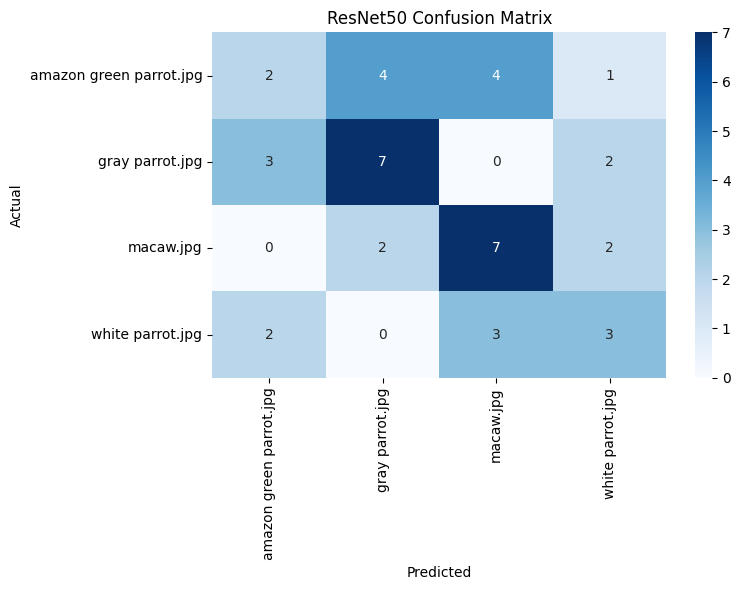

In [48]:

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.title("ResNet50 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(f"{RESULT_DIR}/confusion_matrix.png")
plt.show()
